# Model Building Notebook

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('notebook')
sns.set_style('white')

%matplotlib inline

import pymc3 as pm
import arviz as az

az.rcParams["plot.max_subplots"] = 50

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Data

In [2]:
data = pd.read_csv('prepared_data_2.csv')
data.head()

,FLAG_GENDER_MALE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,OCCUPATION_TYPE,College_Education,Currently_Married,Marriage_Status,Paying_Housing,White_Collar,AGE_YR,YRS_WORKED,target_paid_1
0,0,1,0,0,130500.0,Accountants,0,1,Married,1,1,29.0,3.0,0
1,0,1,0,0,130500.0,Accountants,0,1,Married,1,1,29.0,3.0,0
2,0,0,1,0,157500.0,Laborers,0,1,Married,1,0,27.0,4.0,0
3,0,0,1,0,157500.0,Laborers,0,1,Married,1,0,27.0,4.0,0
4,0,0,1,0,157500.0,Laborers,0,1,Married,1,0,27.0,4.0,0


In [3]:
# Create Clean Copy for Modeling
data_clean = data.copy()

# Transform Hierarchical Variables to Integers
occupation_def = data['OCCUPATION_TYPE'].unique()
data_clean['OCCUPATION_TYPE'].replace(
    occupation_def,
    [x for x in range(len(occupation_def))], 
    inplace=True
)
marriage_def = data['Marriage_Status'].unique()
data_clean['Marriage_Status'].replace(
    marriage_def,
    [x for x in range(len(marriage_def))], 
    inplace=True
)
data_clean.dtypes

FLAG_GENDER_MALE       int64
FLAG_OWN_CAR           int64
FLAG_OWN_REALTY        int64
CNT_CHILDREN           int64
AMT_INCOME_TOTAL     float64
OCCUPATION_TYPE        int64
College_Education      int64
Currently_Married      int64
Marriage_Status        int64
Paying_Housing         int64
White_Collar           int64
AGE_YR               float64
YRS_WORKED           float64
target_paid_1          int64
dtype: object

In [4]:
# Hierarchical Variables
num_occupation = len(data_clean['OCCUPATION_TYPE'].unique())
occupation = data_clean['OCCUPATION_TYPE'].values
num_marriage = len(data_clean['Marriage_Status'].unique())
marriage = data_clean['Marriage_Status'].values

# Numeric Predictors
children = data_clean['CNT_CHILDREN'].values
income = data_clean['AMT_INCOME_TOTAL'].values
age = data_clean['AGE_YR'].values
yrs_worked = data_clean['YRS_WORKED'].values

# Categorical Predictors
male = data_clean['FLAG_GENDER_MALE'].values
car = data_clean['FLAG_OWN_CAR'].values
realty = data_clean['FLAG_OWN_REALTY'].values
college = data_clean['College_Education'].values
married = data_clean['Currently_Married'].values
pay_housing = data_clean['Paying_Housing'].values
white_collar = data_clean['White_Collar'].values

# Interaction Terms
### TBD ###

# Response Variable
target_paid = data_clean['target_paid_1'].values

## Model 1 - Normal GLM

In [5]:
# Make Copy for GLM Model + Make Income Log Transform
data_glm = data_clean.copy()
data_glm['LOG_AMT_INCOME_TOTAL'] = np.log(data_glm['AMT_INCOME_TOTAL'])

In [6]:
# Model Predictors 1 - All Except Hierarchical Predictors, Target, and Log Income
predictors1 = [
    x for x in data_glm.columns 
    if x not in ['OCCUPATION_TYPE', 'Marriage_Status', 'target_paid_1', 'LOG_AMT_INCOME_TOTAL']
]

# Where to Start
start_dict1 = {
    'Intercept': 0.,
    'y': 0.
}
for pred in predictors1:
    start_dict1[pred] = 0.

In [7]:
with pm.Model() as log_model_1:
    
    pm.glm.GLM.from_formula(
        formula = f'''target_paid ~ {" + ".join(predictors1)}''', 
        data = data_glm, 
        family = pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


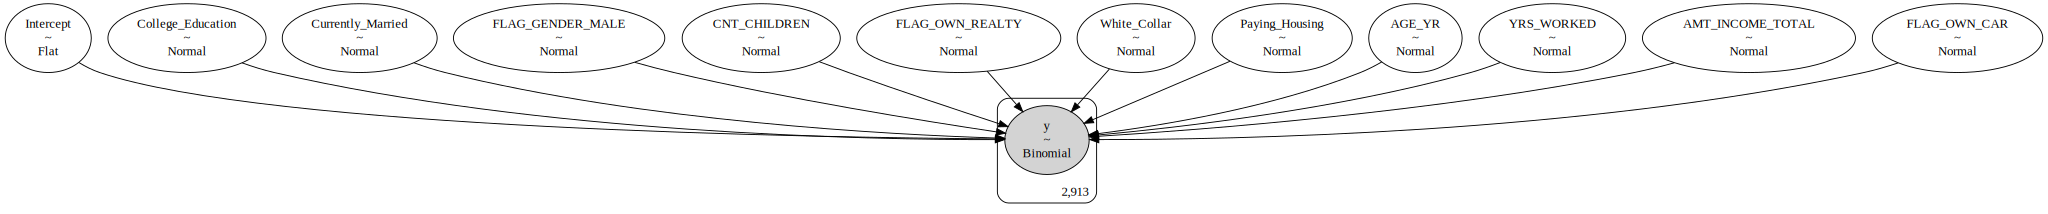

In [8]:
pm.model_to_graphviz(log_model_1)

In [9]:
with log_model_1:
    log_trace_1 = pm.sample(1000, start=start_dict1, chains=8)

C:\Users\Owner\AppData\Local\Temp\ipykernel_11788\3164065839.py:2: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  log_trace_1 = pm.sample(1000, start=start_dict1, chains=8)
C:\Users\Owner\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 2 jobs)
NUTS: [YRS_WORKED, AGE_YR, White_Collar, Paying_Housing, Currently_Married, College_Education, AMT_INCOME_TOTAL, CNT_CHILDREN, FLAG_OWN_REALTY, FLAG_OWN_CAR, FLAG_GENDER_MALE, Intercept]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 483 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.


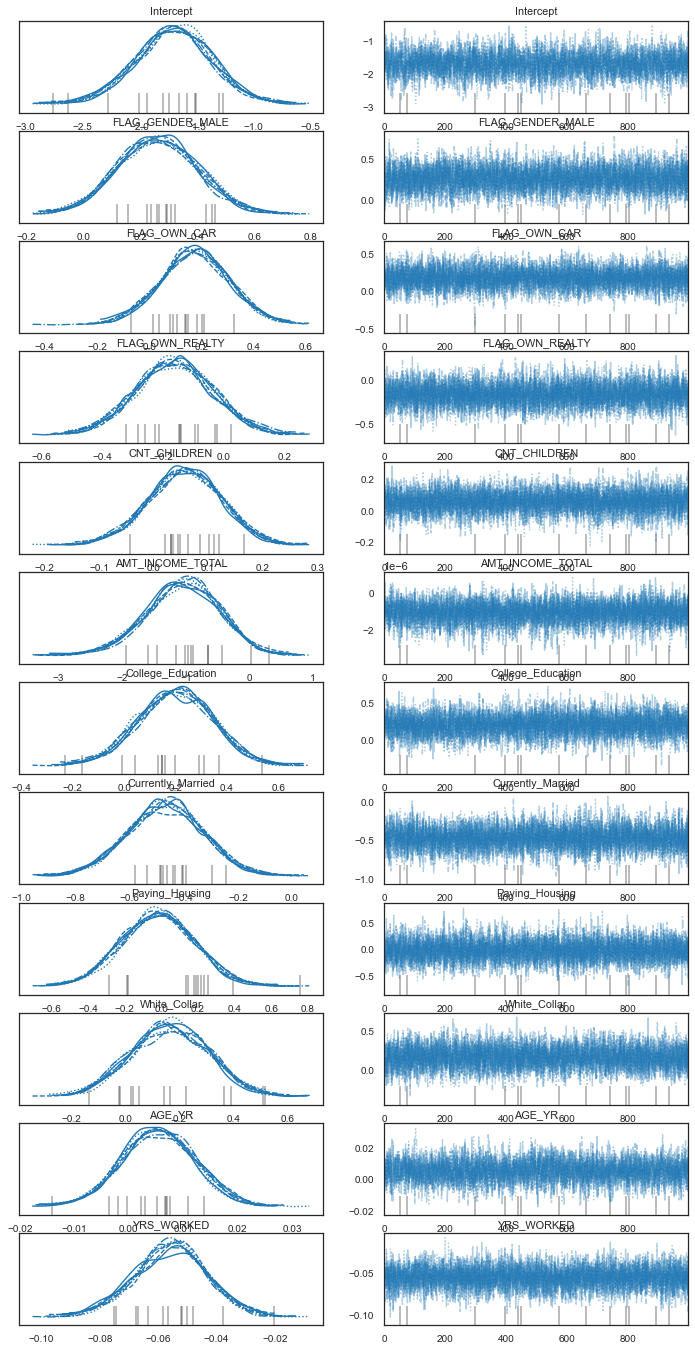

In [10]:
with log_model_1:
    az.plot_trace(log_trace_1)

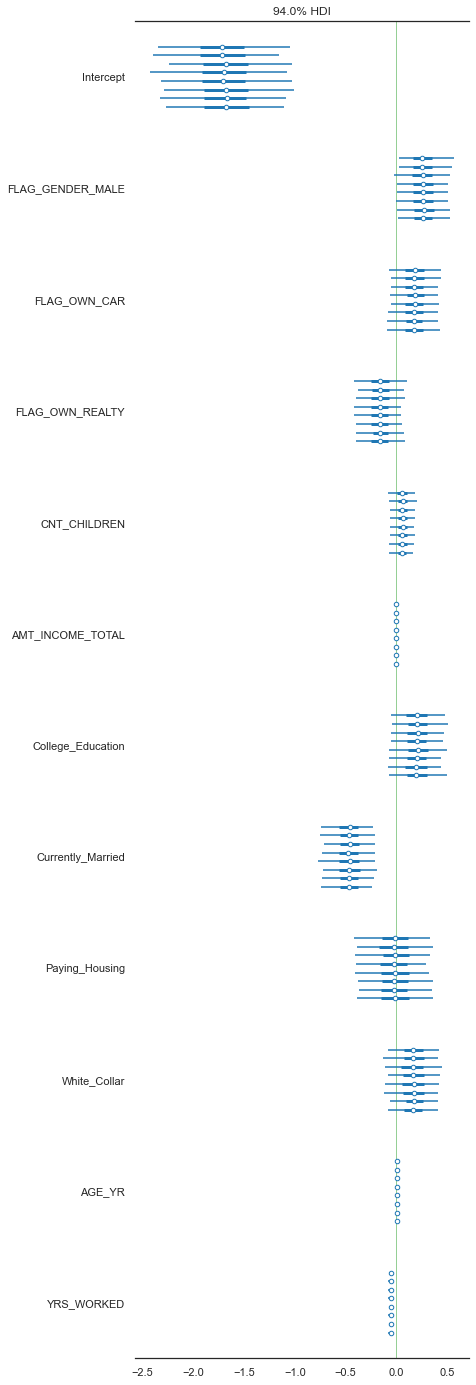

In [11]:
with log_model_1:
    az.plot_forest(log_trace_1, rope=(0, 0))

In [12]:
# Summary Statistics
with log_model_1:
    lm1_sum = pm.summary(log_trace_1)
    
lm1_sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.698,0.335,-2.314,-1.045,0.006,0.004,3432.0,4066.0,1.0
FLAG_GENDER_MALE,0.261,0.141,-0.011,0.518,0.002,0.002,4385.0,4714.0,1.0
FLAG_OWN_CAR,0.176,0.131,-0.062,0.434,0.002,0.001,6105.0,5521.0,1.0
FLAG_OWN_REALTY,-0.163,0.126,-0.401,0.077,0.002,0.001,6050.0,5293.0,1.0
CNT_CHILDREN,0.057,0.067,-0.074,0.180,0.001,0.001,5330.0,4249.0,1.0
AMT_INCOME_TOTAL,-0.000,0.000,-0.000,0.000,0.000,0.000,5748.0,4881.0,1.0
College_Education,0.199,0.144,-0.076,0.464,0.002,0.001,5263.0,5159.0,1.0
Currently_Married,-0.468,0.140,-0.742,-0.217,0.002,0.001,5702.0,5472.0,1.0
Paying_Housing,-0.017,0.199,-0.393,0.349,0.003,0.002,5880.0,5439.0,1.0
White_Collar,0.166,0.142,-0.109,0.418,0.002,0.002,4761.0,4959.0,1.0


## Models 2 - Normal GLM + Log Income

In [13]:
# Model Predictors 1 - All Except Hierarchical Predictors, Target, and Normal Income
predictors2 = [
    x for x in data_glm.columns 
    if x not in ['OCCUPATION_TYPE', 'Marriage_Status', 'target_paid_1', 'AMT_INCOME_TOTAL']
]

# Where to Start
start_dict2 = {
    'Intercept': 0.,
    'y': 0.
}
for pred in predictors2:
    start_dict2[pred] = 0.

In [14]:
with pm.Model() as log_model_2:
    
    pm.glm.GLM.from_formula(
        formula = f'''target_paid ~ {" + ".join(predictors2)}''', 
        data = data_glm, 
        family = pm.glm.families.Binomial())

The glm module is deprecated and will be removed in version 4.0
We recommend to instead use Bambi https://bambinos.github.io/bambi/


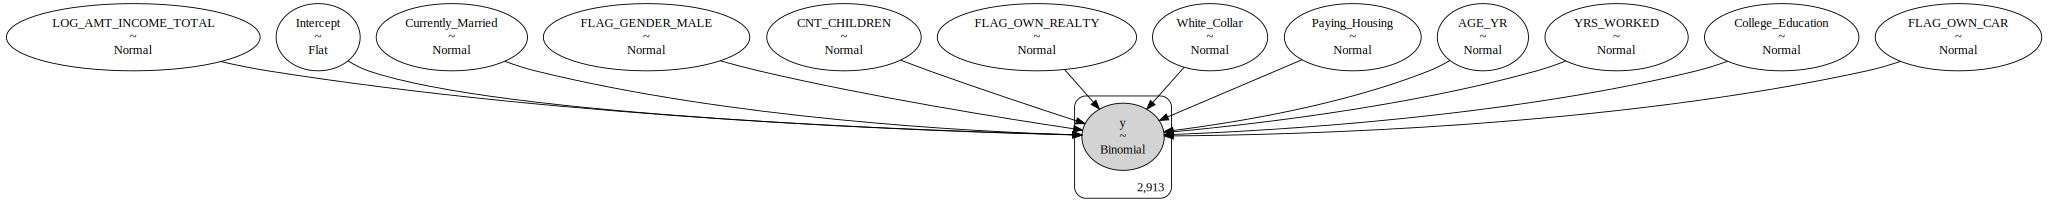

In [15]:
pm.model_to_graphviz(log_model_2)

In [16]:
with log_model_2:
    log_trace_2 = pm.sample(1000, start=start_dict2, chains=8)

C:\Users\Owner\AppData\Local\Temp\ipykernel_11788\1830762541.py:2: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  log_trace_2 = pm.sample(1000, start=start_dict2, chains=8)
C:\Users\Owner\anaconda3\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 2 jobs)
NUTS: [LOG_AMT_INCOME_TOTAL, YRS_WORKED, AGE_YR, White_Collar, Paying_Housing, Currently_Married, College_Education, CNT_CHILDREN, FLAG_OWN_REALTY, FLAG_OWN_CAR, FLAG_GENDER_MALE, Intercept]


Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 1059 seconds.
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


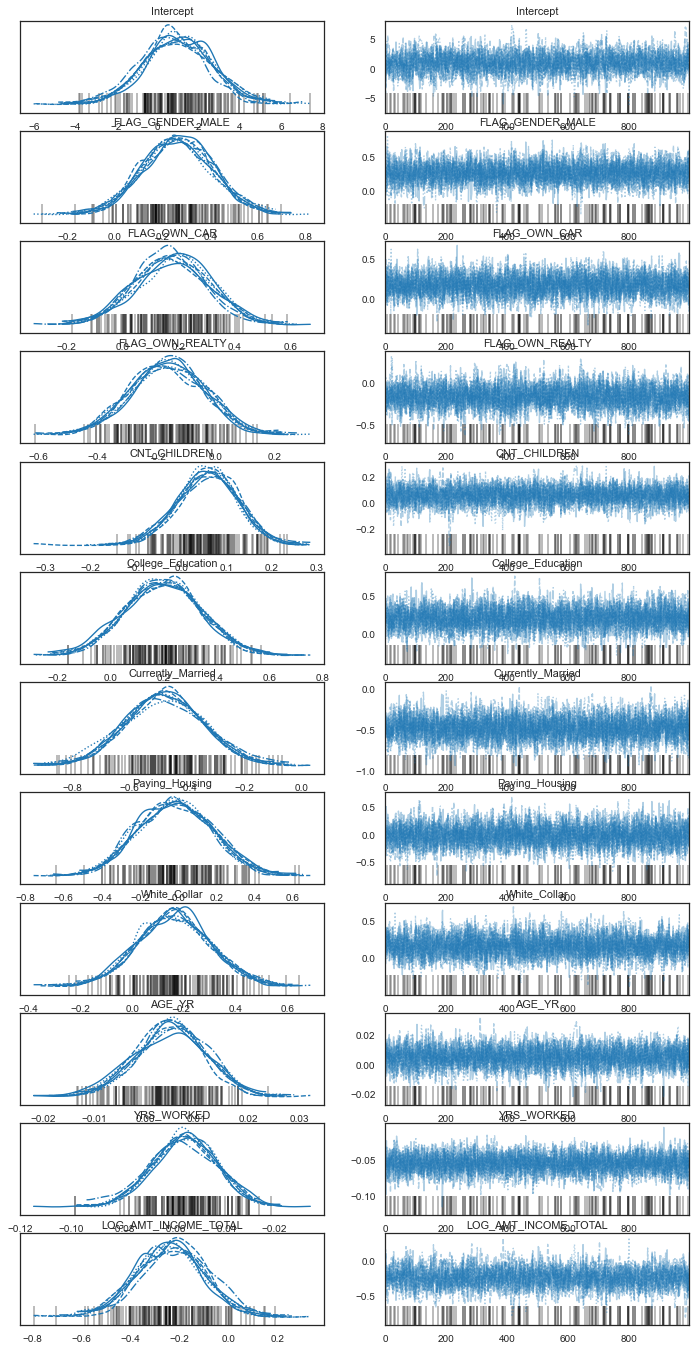

In [17]:
with log_model_2:
    az.plot_trace(log_trace_2)

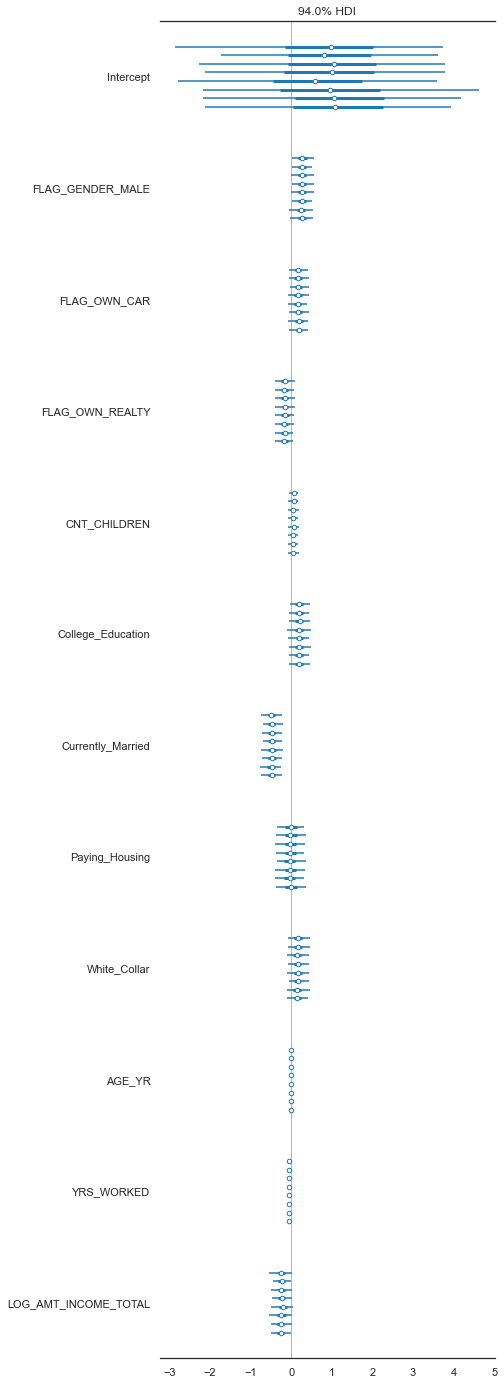

In [18]:
with log_model_2:
    az.plot_forest(log_trace_2, rope=(0, 0))

In [19]:
# Summary Statistics
with log_model_2:
    lm2_sum = pm.summary(log_trace_2)
    
lm2_sum

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.956,1.671,-2.179,4.035,0.041,0.029,1686.0,1906.0,1.01
FLAG_GENDER_MALE,0.263,0.147,0.002,0.553,0.003,0.002,2461.0,2876.0,1.00
FLAG_OWN_CAR,0.178,0.130,-0.072,0.414,0.002,0.002,2799.0,3902.0,1.00
FLAG_OWN_REALTY,-0.161,0.127,-0.405,0.066,0.002,0.002,2837.0,3327.0,1.00
CNT_CHILDREN,0.058,0.068,-0.073,0.179,0.001,0.001,2497.0,3168.0,1.00
College_Education,0.199,0.142,-0.058,0.471,0.003,0.002,2947.0,3303.0,1.00
Currently_Married,-0.477,0.138,-0.739,-0.221,0.003,0.002,2940.0,2784.0,1.00
Paying_Housing,-0.016,0.196,-0.382,0.346,0.004,0.003,2840.0,3597.0,1.00
White_Collar,0.162,0.142,-0.097,0.443,0.003,0.002,2580.0,3307.0,1.00
AGE_YR,0.005,0.007,-0.008,0.017,0.000,0.000,2262.0,2838.0,1.01


## Model 3 - No Offsets

In [ ]:
with pm.Model() as log_hier_model_2:
    
    ## HyperParameters for Predictors ##
    
    # Intercept
    mu_b0 = pm.Normal('mu_b0', mu=0, sigma=5)
    sigma_b0 = pm.HalfCauchy('sigma_b0', beta=5)
    
    # Children
    mu_b1 = pm.Normal('mu_b1', mu=0, sigma=5)
    sigma_b1 = pm.HalfCauchy('sigma_b1', beta=5)
    
    # Income
    mu_b2 = pm.Normal('mu_b2', mu=0, sigma=5)
    sigma_b2 = pm.HalfCauchy('sigma_b2', beta=5)
    
    # Age
    mu_b3 = pm.Normal('mu_b3', mu=0, sigma=5)
    sigma_b3 = pm.HalfCauchy('sigma_b3', beta=5)
    
    # Years Worked
    mu_b4 = pm.Normal('mu_b4', mu=0, sigma=5)
    sigma_b4 = pm.HalfCauchy('sigma_b4', beta=5)
    
    # Male
    mu_b5 = pm.Normal('mu_b5', mu=0, sigma=5)
    sigma_b5 = pm.HalfCauchy('sigma_b5', beta=5)
    
    # Car
    mu_b6 = pm.Normal('mu_b6', mu=0, sigma=5)
    sigma_b6 = pm.HalfCauchy('sigma_b6', beta=5)
    
    # Realty
    mu_b7 = pm.Normal('mu_b7', mu=0, sigma=5)
    sigma_b7 = pm.HalfCauchy('sigma_b7', beta=5)
    
    # College
    mu_b8 = pm.Normal('mu_b8', mu=0, sigma=5)
    sigma_b8 = pm.HalfCauchy('sigma_b8', beta=5)
    
    # Married
    mu_b9 = pm.Normal('mu_b9', mu=0, sigma=5)
    sigma_b9 = pm.HalfCauchy('sigma_b9', beta=5)
    
    # Pay Housing
    mu_b10 = pm.Normal('mu_b10', mu=0, sigma=5)
    sigma_b10 = pm.HalfCauchy('sigma_b10', beta=5)
    
    # White Collar
    mu_b11 = pm.Normal('mu_b11', mu=0, sigma=5)
    sigma_b11 = pm.HalfCauchy('sigma_b11', beta=5)
    
    
    ## Hierarchical Predictors ##
    
    # Intercept
    b0 = pm.Normal('b0', mu=mu_b0, sigma=sigma_b0, shape=num_status)
    
    
    ## Predictors ##
    
    # Normal Predictors - Numeric
    b1 = pm.Normal('b', mu=mu_b1, sigma=sigma_b1)
    b2 = pm.Normal('b2', mu=mu_b2, sigma=sigma_b2)
    b3 = pm.Normal('b3', mu=mu_b3, sigma=sigma_b3)
    b4 = pm.Normal('b4', mu=mu_b4, sigma=sigma_b4)
    
    # Normal Predictors - Categorical
    b5 = pm.Normal('b5', mu=mu_b5, sigma=sigma_b5)
    b6 = pm.Normal('b6', mu=mu_b6, sigma=sigma_b6)
    b7 = pm.Normal('b7', mu=mu_b7, sigma=sigma_b7)
    b8 = pm.Normal('b8', mu=mu_b8, sigma=sigma_b8)
    b9 = pm.Normal('b9', mu=mu_b9, sigma=sigma_b9)
    b10 = pm.Normal('b10', mu=mu_b10, sigma=sigma_b10)
    b11 = pm.Normal('b11', mu=mu_b11, sigma=sigma_b11)
    
    
    ## Model ##
    
    # Regression Equation
    linear_function = b0[status] + b1*children + b2*income +  b3*age + b4*yrs_worked + b5*male + /
                      b6*car + b7*realty + b8*college + b9*married + b10*pay_housing + b11*white_collar
        
    # # Trying Out Subsets of Variables
    # linear_function = b0 + b1*children +  b3*age + b4*yrs_worked + b5*male 
    
    # Convert to Logistic
    p = pm.invlogit(linear_function)
    y = pm.Bernoulli('y', p, observed=target_paid)

In [ ]:
pm.model_to_graphviz(log_hier_model_3)

In [ ]:
with log_hier_model_3:
    
    step = None
    # step = pm.NUTS(target_accept = 0.99)
    
    # cores = None
    cores = 1
    
    # chains = None
    chains = 2
    
    samples = 3000
    
    log_hier_trace_3 = pm.sample(samples, tune=samples, chains=chains, step = step, cores=cores)

In [ ]:
with log_hier_model_3:
    az.plot_trace(log_hier_trace_3)

In [ ]:
with log_hier_model_3:
    az.plot_forest(log_hier_trace_3, rope=(0, 0))